# Accelerating Large Language Model Inference with Medusa on Amazon SageMaker

This notebook supports setting up and running Medusa, a technique introduced in the ["Medusa: Simple LLM Inference
Acceleration Framework with Multiple Decoding Heads"](https://arxiv.org/abs/2401.10774) paper, on [Amazon SageMaker](https://aws.amazon.com/pm/sagemaker/?gclid=Cj0KCQjwmOm3BhC8ARIsAOSbapVEm--Q2sgQ7QFKgdo5epDmZZ0g8uYJ1sFPVbSQpbdizEkDTP5hVB0aAjXoEALw_wcB&trk=3ea5c9d1-0497-4ab3-92e6-c583f43ac2f9&sc_channel=ps&ef_id=Cj0KCQjwmOm3BhC8ARIsAOSbapVEm--Q2sgQ7QFKgdo5epDmZZ0g8uYJ1sFPVbSQpbdizEkDTP5hVB0aAjXoEALw_wcB:G:s&s_kwcid=AL!4422!3!645186192649!e!!g!!amazon%20sagemaker!19571721771!146073031580).

This notebook is a modified version of the original [How to Fine-Tune LLMs in 2024 on Amazon SageMaker](https://github.com/philschmid/llm-sagemaker-sample/blob/main/notebooks/train-evalaute-llms-2024-trl.ipynb) example by [Philipp Schmid](https://www.philschmid.de/philipp-schmid). We added a simplified Medusa training code, adapted from the original [Medusa framework repository](https://github.com/FasterDecoding/Medusa).  We use a dataset called [sql-create-context](https://huggingface.co/datasets/b-mc2/sql-create-context), which contains samples of natural language instructions, schema definitions and the corresponding SQL query.

We cover the following steps in this repository:
1. Load and prepare the dataset
2. Fine-tune an LLM using SageMaker Training Job
3. Train Medusa heads on top of frozen fine-tuned LLM using SageMaker Training Job
4. Deploy the fine-tuned LLM with Medusa heads on SageMaker Endpoint
5. Demonstrate LLM inference speedup: We compare average latencies between fine-tuned LLM and the fine-tuned LLM with Medusa heads.



# Setup Development Environment

In [3]:
%pip install  --upgrade \
  "transformers==4.44.2" \
  "sagemaker>=2.190.0" \
  "datasets==2.21.0" \
  "evaluate==0.4.2" \
  "s3fs==0.4.2"

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached sagemaker-2.237.0-py3-none-any.whl.metadata (16 kB)
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached boto3-1.35.79-py3-none-any.whl.metadata (6.7 kB)
  Using cached omegaconf-2.2.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached sagemaker_core-1.0.17-py3-none-any.whl.metadata (4.9 kB)
  Using cached uvicorn-0.32.1-py3-none-any.whl.metadata (6.6 kB)
  Using cached botocore-1.35.79-py3-none-any.whl.metadata (5.7 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 674.

In [28]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::110266750413:role/service-role/AmazonSageMaker-ExecutionRole-20210122T111983
sagemaker bucket: sagemaker-us-east-1-110266750413
sagemaker session region: us-east-1


# 1. Load and prepare the dataset

In [29]:
def create_conversation(sample):
    system_message = """You are an text to SQL query translator. \
    Users will ask you questions in English \
    and you will generate a SQL query based on the provided SCHEMA.
    SCHEMA:
    {schema}"""
    return {
    "messages": [
      {"role": "system", "content": system_message.format(schema=sample["context"])},
      {"role": "user", "content": sample["question"]},
      {"role": "assistant", "content": sample["answer"]}
    ]
  }  

In [30]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
seed = 42
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle(seed=seed).select(range(3000))
dataset[0]

{'answer': 'SELECT venue FROM table_name_50 WHERE away_team = "essendon"',
 'question': 'When Essendon played away; where did they play?',
 'context': 'CREATE TABLE table_name_50 (venue VARCHAR, away_team VARCHAR)'}

In [31]:
dataset = dataset.map(create_conversation ,batched=False)
dataset = dataset.remove_columns(["answer", "question", "context"])

dataset[0]

{'messages': [{'content': 'You are an text to SQL query translator.     Users will ask you questions in English     and you will generate a SQL query based on the provided SCHEMA.\n    SCHEMA:\n    CREATE TABLE table_name_50 (venue VARCHAR, away_team VARCHAR)',
   'role': 'system'},
  {'content': 'When Essendon played away; where did they play?',
   'role': 'user'},
  {'content': 'SELECT venue FROM table_name_50 WHERE away_team = "essendon"',
   'role': 'assistant'}]}

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer


def calculate_token_lengths(sample, tokenizer):
    system_tokens = tokenizer(sample["messages"][0]["content"], truncation=False)['input_ids']
    prompt_tokens = tokenizer(sample["messages"][1]["content"], truncation=False)['input_ids']
    completion_tokens = tokenizer(sample["messages"][2]["content"], truncation=False)['input_ids']
    return {
        'system_tokens': len(system_tokens),
        'prompt_tokens': len(prompt_tokens),
        'completion_tokens': len(completion_tokens),
        'total_tokens': len(system_tokens) + len(prompt_tokens) + len(completion_tokens)
    }


def display_token_distribution_and_percentiles(dataset, tokenizer):
    token_lengths = dataset.map(lambda x: calculate_token_lengths(x, tokenizer), batched=False)

    lengths_dict = {
        'Prompt (Input)': np.array(token_lengths['prompt_tokens']),
        'Completion (Output)': np.array(token_lengths['completion_tokens']),
        'Combined (Input + Output)': np.array(token_lengths['total_tokens'])
    }

    plt.figure(figsize=(10, 8))
    for i, (label, lengths) in enumerate(lengths_dict.items(), 1):
        plt.subplot(len(lengths_dict.items()), 1, i)
        plt.hist(lengths, bins=50, alpha=0.7, label=label)
        plt.title(f'Token Length Distribution for {label}')
        plt.xlabel('Token Length')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

    def print_summary_statistics(data, label):
        print(f"\n{label} Token Length Summary:")
        df = pd.Series(data)
        print(df.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

    for label, lengths in lengths_dict.items():
        print_summary_statistics(lengths, label)

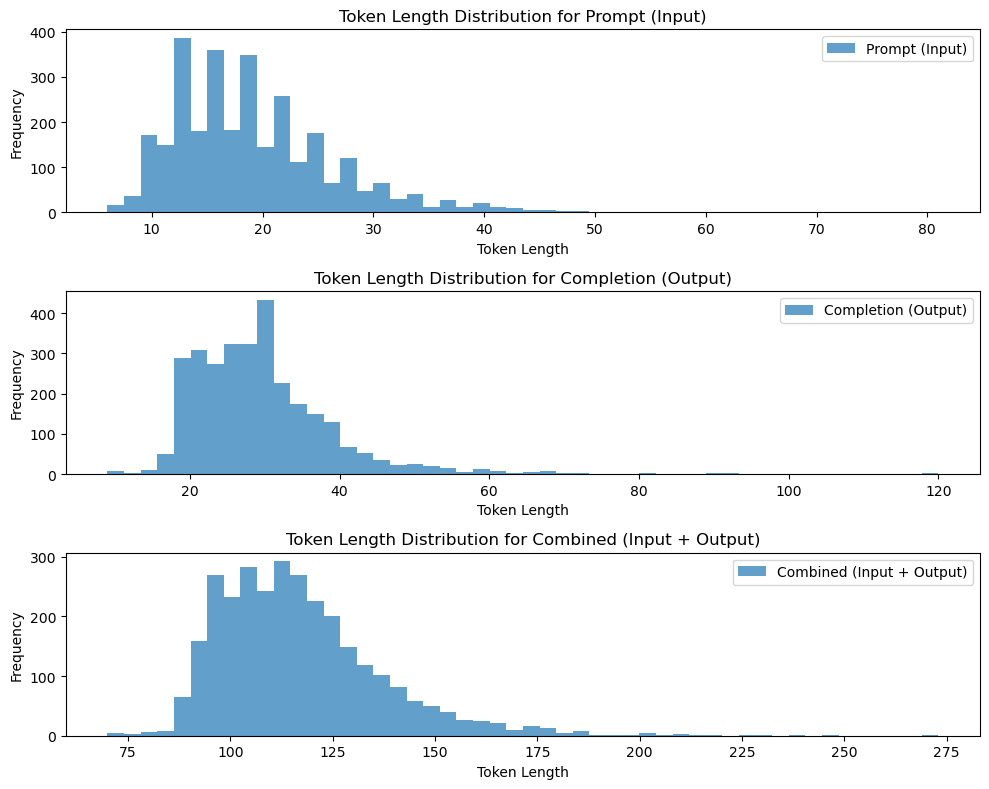


Prompt (Input) Token Length Summary:
count    3000.000000
mean       18.864000
std         7.326577
min         6.000000
50%        18.000000
75%        23.000000
90%        28.000000
95%        33.000000
99%        41.010000
max        81.000000
dtype: float64

Completion (Output) Token Length Summary:
count    3000.000000
mean       29.603000
std         9.879267
min         9.000000
50%        28.000000
75%        34.000000
90%        40.100000
95%        46.000000
99%        65.010000
max       120.000000
dtype: float64

Combined (Input + Output) Token Length Summary:
count    3000.000000
mean      117.025333
std        20.604131
min        70.000000
50%       114.000000
75%       126.000000
90%       143.000000
95%       155.000000
99%       184.000000
max       273.000000
dtype: float64


In [33]:
model_id = "HuggingFaceH4/zephyr-7b-beta"           # or `mistralai/Mistral-7B-v0.1`
tokenizer = AutoTokenizer.from_pretrained(model_id)
display_token_distribution_and_percentiles(dataset, tokenizer)

In [34]:
train_test_split = dataset.train_test_split(test_size=0.3, seed=seed)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=seed)

dataset = {
    'train': train_test_split['train'],
    'val': val_test_split['train'],  # The 'train' key here refers to the validation set
    'test': val_test_split['test']
}

# Check the number of examples in each split
print(f"Training set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['val'])}")
print(f"Test set size: {len(dataset['test'])}")

Training set size: 2100
Validation set size: 450
Test set size: 450


In [35]:
# save train_dataset to s3 using our SageMaker session
data_input_path = f's3://{sess.default_bucket()}/datasets/text-to-sql'

train_dataset_path = f"{data_input_path}/train/train_dataset.json"
eval_dataset_path = f"{data_input_path}/eval/eval_dataset.json"
test_dataset_path = f"{data_input_path}/test/test_dataset.json"

# save datasets to s3
dataset["train"].to_json(train_dataset_path, orient="records")
dataset["val"].to_json(eval_dataset_path, orient="records")
dataset["test"].to_json(test_dataset_path, orient="records")

print(f"Training data uploaded to: {data_input_path}")

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Training data uploaded to: s3://sagemaker-us-east-1-110266750413/datasets/text-to-sql


# 2. Fine-tune an LLM using SageMaker Training Job

In [41]:
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.debugger import TensorBoardOutputConfig
import time
import os

def get_current_time():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())

def create_estimator(hyperparameters_dict, job_name, role, sess, train_scipt_path):
    metric=[
        {"Name": "loss", "Regex": r"'loss':\s*([0-9.]+)"},
        {"Name": "epoch", "Regex": r"'epoch':\s*([0-9.]+)"},
    ]

    tensorboard_s3_output_path = os.path.join(
       "s3://", sess.default_bucket(), job_name, 'tensorboard'
    )
    print("Tensorboard output path:", tensorboard_s3_output_path)

    tensorboard_output_config = TensorBoardOutputConfig(
        s3_output_path=tensorboard_s3_output_path,
        container_local_output_path=hyperparameters_dict['logging_dir']
    )
    estimator = PyTorch(
        sagemaker_session    = sess,
        entry_point          = train_scipt_path,    # train script
        source_dir           = 'train',      # directory which includes all the files needed for training
        instance_type        = 'ml.g5.4xlarge',   # instances type used for the training job, "local_gpu" for local mode
        metric_definitions   = metric,
        instance_count       = 1,                 # the number of instances used for training
        role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
        volume_size          = 300,               # the size of the EBS volume in GB
        framework_version      = '2.1.0',             # the pytorch_version version used in the training job
        py_version           = 'py310',           # the python version used in the training job
        hyperparameters      =  hyperparameters_dict,  # the hyperparameters passed to the training job
        disable_output_compression = True,        # not compress output to save training time and cost
        tensorboard_output_config = tensorboard_output_config,
        environment          = {
                                "HF_DATASETS_CACHE": "opt/ml/input/",
                                "TRANSFORMERS_CACHE": "opt/ml/input/",
                                "HUGGINGFACE_HUB_CACHE": "opt/ml/input/", # set env variable to cache models in /tmp
                                "HF_ENDPOINT": "https://hf-mirror.com"
                            }, 
    )
    return estimator

In [42]:
# hyperparameters, which are passed into the training job
sft_hyperparameters = {
  ### SCRIPT PARAMETERS ###
  'train_dataset_path': '/opt/ml/input/data/train/train_dataset.json', # path where sagemaker will save training dataset
  'eval_dataset_path': '/opt/ml/input/data/eval/eval_dataset.json', # path where sagemaker will save evaluation dataset
  'model_id': model_id,
  'max_seq_len': 256,                               # max sequence length for model and packing of the dataset
  'use_qlora': True,                                 # use QLoRA model
  ### TRAINING PARAMETERS ###
  'num_train_epochs': 1,                             # number of training epochs
  'per_device_train_batch_size': 1,                  # batch size per device during training
  'gradient_accumulation_steps': 16,                  # number of steps before performing a backward/update pass
  'gradient_checkpointing': True,                    # use gradient checkpointing to save memory
  'optim': "adamw_8bit",                             # use fused adamw 8bit optimizer
  'logging_steps': 15,                               # log every 10 steps
  'save_strategy': "steps",                          # save checkpoint every epoch
  'save_steps': 15,
  'save_total_limit': 2,
  'eval_strategy': "steps",
  'eval_steps': 15,
  'learning_rate': 1e-4,                             # learning rate, based on QLoRA paper
  'bf16': True,                                      # use bfloat16 precision
  'max_grad_norm': 10,                              # max gradient norm based on QLoRA paper
  'warmup_ratio': 0.03,                              # warmup ratio based on QLoRA paper
  'lr_scheduler_type': "constant",                   # use constant learning rate scheduler
  'output_dir': '/opt/ml/checkpoints/',              # Temporary output directory for model checkpoints
  'merge_adapters': True,                            # merge LoRA adapters into model for easier deployment
  'report_to': "tensorboard",                        # report metrics to tensorboard
  'logging_dir': "/opt/ml/output/tensorboard"        # tensorboard logging directory
}

In [43]:
sft_job_name = f"sft-qlora-text-to-sql-{get_current_time()}"
data = {
    'train': train_dataset_path,
    'eval': eval_dataset_path
}

sft_estimator = create_estimator(sft_hyperparameters, sft_job_name, role, sess, "fine_tune_llm.py")

Tensorboard output path: s3://sagemaker-us-east-1-110266750413/sft-qlora-text-to-sql-2024-12-12-18-59-56/tensorboard


In [44]:
# This will take around 1 hour
sft_estimator.fit(job_name=sft_job_name, inputs=data, wait=False)

[12/12/24 18:59:57] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=35384;file:///opt/conda/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=342741;file:///opt/conda/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=234970;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=630783;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=862051;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=78480;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sft-qlora-text-to-sql-2024-12-12-18-59-56                                             

In [40]:
fine_tuned_model_path = f's3://{sess.default_bucket()}/{sft_job_name}/output/model/'

To visualize the training metrics in Tensorboard, you can follow the guidance in this documentation: [Load and visualize output tensors using the TensorBoard application](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-htb-access-tb-data.html)

![Tensorboard](tensorboard.png)

# 3. Train Medusa heads on top of frozen fine-tuned LLM using SageMaker Training Job

In [158]:
# hyperparameters, which are passed into the training job
medusa_hyperparameters = {
  ### SCRIPT PARAMETERS ###
  'train_dataset_path': '/opt/ml/input/data/train/train_dataset.json', # path where sagemaker will save training dataset
  'eval_dataset_path': '/opt/ml/input/data/eval/eval_dataset.json', # path where sagemaker will save evaluation dataset
  'model_path': '/opt/ml/input/data/fine-tuned-model/',
  'max_seq_len': 256,                               # max sequence length for model and packing of the dataset
  'medusa_num_heads': 5,
  ### TRAINING PARAMETERS ###
  'num_train_epochs': 3,                             # number of training epochs
  'per_device_train_batch_size': 1,                  # batch size per device during training
  'gradient_accumulation_steps': 16,                  # number of steps before performing a backward/update pass
  'gradient_checkpointing': True,                    # use gradient checkpointing to save memory
  'optim': "adamw_8bit",                             # use fused adamw 8bit optimizer
  'logging_steps': 15,                               # log every 10 steps
  'save_strategy': "steps",                          # save checkpoint every epoch
  'save_steps': 15,
  'save_total_limit':2,
  'eval_strategy': "steps",
  'eval_steps': 15,
  'learning_rate': 1e-4,                             # learning rate
  'bf16': True,                                      # use bfloat16 precision
  'max_grad_norm': 10,                              # max gradient norm based on QLoRA paper
  'warmup_ratio': 0.03,                              # warmup ratio based on QLoRA paper
  'lr_scheduler_type': "constant",                   # use constant learning rate scheduler
  'output_dir': '/opt/ml/checkpoints/',              # Temporary output directory for model checkpoints
  'report_to': "tensorboard",                        # report metrics to tensorboard
  'logging_dir': "/opt/ml/output/tensorboard"        # tensorboard logging directory
}

In [159]:
medusa_train_job_name = f"medusa-text-to-sql-{get_current_time()}"
data = {
    'train': train_dataset_path,
    'eval': eval_dataset_path,
    'fine-tuned-model': fine_tuned_model_path
}

medusa_estimator = create_estimator(medusa_hyperparameters, medusa_train_job_name, role, sess, "train_medusa_heads.py")

Tensorboard output path: s3://sagemaker-us-east-1-110266750413/medusa-text-to-sql-2024-11-08-18-30-54/tensorboard


In [160]:
# This will take around 1 hour
medusa_estimator.fit(job_name=medusa_train_job_name, inputs=data, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: medusa-text-to-sql-2024-11-08-18-30-54


In [168]:
medusa_trained_model_path = f's3://{sess.default_bucket()}/{medusa_train_job_name}/output/model/'

# 5. Deploy the fine-tuned LLM with Medusa heads on SageMaker Endpoint

In [74]:
import json
from sagemaker.huggingface import HuggingFaceModel, get_huggingface_llm_image_uri
import concurrent.futures


def deploy_model(endpoint_name, model_s3_path=None, hf_model_id=None):
    llm_image = get_huggingface_llm_image_uri(
      "huggingface",
      version="2.2.0",
      session=sess,
    )

    print(f"llm image uri: {llm_image}")

    model_data = None
    if model_s3_path:
        model_data = {'S3DataSource': {'S3Uri': model_s3_path, 'S3DataType': 'S3Prefix', 'CompressionType': 'None'}}
        hf_model_id = "/opt/ml/model"
    else:
        assert hf_model_id, "You need to provide either pretrained HF model id, or S3 model data to deploy"
    config = {
      'HF_MODEL_ID': hf_model_id,  # path to where sagemaker stores the model
      'SM_NUM_GPUS': json.dumps(1),  # Number of GPU used per replica
      'MAX_INPUT_LENGTH': json.dumps(1024),  # Max length of input text
      'MAX_TOTAL_TOKENS': json.dumps(2048),  # Max length of the generation (including input text)
    }

    llm_model = HuggingFaceModel(
      name=endpoint_name,
      role=role,
      image_uri=llm_image,
      model_data=model_data,
      env=config
    )

    endpoint = llm_model.deploy(
      endpoint_name=endpoint_name,
      initial_instance_count=1,
      instance_type="ml.g5.2xlarge",
      container_startup_health_check_timeout=300,
    )
    return endpoint


def deploy_models(endpoints_list):
    """
    Deploys multiple models concurrently by calling deploy_model()
    """
    endpoints = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(deploy_model, endpoint_name=item["endpoint_name"], 
                                   model_s3_path=item["model_s3_path"], 
                                   hf_model_id=item["hf_model_id"]): i 
                   for i, item in enumerate(endpoints_list)}

        for future in concurrent.futures.as_completed(futures):
            index = futures[future]
            try:
                result = future.result()
                print(f"Endpoint {index} deployed: {result}")
                endpoints.append((index, result))
            except Exception as exc:
                print(f"Endpoint {index} generated an exception: {exc}")

    # Sort the results based on the original order
    endpoints.sort(key=lambda x: x[0])
    
    # Return just the endpoints, without the index
    return [endpoint for _, endpoint in endpoints]

We depoy 3 LLMs on 3 SageMaker endpoints:
1.  Base LLM from huggingface which is not fine-tuned
2.  The LLM that we fine-tuned
3.  The fine-tuned LLM that has also trained Medusa heads

Make sure that your account-level service limit 'ml.g5.2xlarge for endpoint usage' is set to at least 3 Instances. Please use AWS Service Quotas to request an increase for this quota. 

In [75]:
endpoints_list = [
    {
        "endpoint_name": f"base-{get_current_time()}",
        "model_s3_path": None,
        "hf_model_id": model_id
    },
    {
        "endpoint_name": f"sft-{get_current_time()}",
        "model_s3_path": fine_tuned_model_path,
        "hf_model_id": None
    }, 
    {
        "endpoint_name": f"medusa-{get_current_time()}",
        "model_s3_path": medusa_trained_model_path,
        "hf_model_id": None
    },
]

In [76]:
base_deployed_llm, sft_deployed_llm, medusa_deployed_llm = deploy_models(endpoints_list)

[12/17/24 17:08:38] INFO     Defaulting to only available Python version: py310                   ]8;id=518372;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=616836;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#604\604]8;;\

                    INFO     Defaulting to only available Python version: py310                   ]8;id=448114;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=606096;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#604\604]8;;\

                    INFO     Defaulting to only available Python version: py310                   ]8;id=636919;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=923432;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#604\604]8;;\

                    INFO     Defaulting to only supported image scope: gpu.                       ]8;id=979099;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=820066;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

llm image uri: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-tgi-inference:2.3.0-tgi2.2.0-gpu-py310-cu121-ubuntu22.04-v2.0


                    INFO     Defaulting to only supported image scope: gpu.                       ]8;id=173023;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=965739;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

llm image uri: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-tgi-inference:2.3.0-tgi2.2.0-gpu-py310-cu121-ubuntu22.04-v2.0


                    INFO     Defaulting to only supported image scope: gpu.                       ]8;id=642333;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=390913;file:///opt/conda/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

llm image uri: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-tgi-inference:2.3.0-tgi2.2.0-gpu-py310-cu121-ubuntu22.04-v2.0


[12/17/24 17:08:39] INFO     Creating model with name: sft-2024-12-17-17-08-20                      ]8;id=747667;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=182787;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating model with name: base-2024-12-17-17-08-20                     ]8;id=646644;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=573846;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating model with name: medusa-2024-12-17-17-08-20                   ]8;id=822260;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=716802;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[12/17/24 17:08:40] INFO     Creating endpoint-config with name base-2024-12-17-17-08-20            ]8;id=897118;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=854596;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint-config with name medusa-2024-12-17-17-08-20          ]8;id=894048;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=615830;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint-config with name sft-2024-12-17-17-08-20             ]8;id=870951;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=127631;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name base-2024-12-17-17-08-20                   ]8;id=1369;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=507256;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

                    INFO     Creating endpoint with name medusa-2024-12-17-17-08-20                 ]8;id=811686;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=552438;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

                    INFO     Creating endpoint with name sft-2024-12-17-17-08-20                    ]8;id=263274;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=685345;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

------------------------------------!Endpoint 0 deployed: HuggingFacePredictor: {'endpoint_name': 'base-2024-12-17-17-08-20', 'sagemaker_session': <sagemaker.session.Session object at 0x7fa342894c10>, 'serializer': <sagemaker.base_serializers.JSONSerializer object at 0x7fa3423a55a0>, 'deserializer': <sagemaker.base_deserializers.JSONDeserializer object at 0x7fa3423a50f0>}
!Endpoint 2 deployed: HuggingFacePredictor: {'endpoint_name': 'medusa-2024-12-17-17-08-20', 'sagemaker_session': <sagemaker.session.Session object at 0x7fa339b7ac80>, 'serializer': <sagemaker.base_serializers.JSONSerializer object at 0x7fa3423a55a0>, 'deserializer': <sagemaker.base_deserializers.JSONDeserializer object at 0x7fa3423a50f0>}
-!Endpoint 1 deployed: HuggingFacePredictor: {'endpoint_name': 'sft-2024-12-17-17-08-20', 'sagemaker_session': <sagemaker.session.Session object at 0x7fa342894ac0>, 'serializer': <sagemaker.base_serializers.JSONSerializer object at 0x7fa3423a55a0>, 'deserializer': <sagemaker.base_des

We can see in below example that the repsonses for the same request differ for each model: 
1. The base LLM response contains extra words which are not needed
2. The fine-tuned LLM response is improved significantly (thanks to fine-tuning) and contains only the required output
3. The fine-tuned LLM with trained Medusa heads provides the same response as the fine-tuned model

In [77]:
from transformers import AutoTokenizer
from sagemaker.s3 import S3Downloader

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the test dataset from s3
S3Downloader.download(test_dataset_path, ".")
test_dataset = load_dataset("json", data_files="test_dataset.json",split="train")
random_sample = test_dataset[3]

print(random_sample["messages"])


Generating train split: 0 examples [00:00, ? examples/s]

[{'content': 'You are an text to SQL query translator.     Users will ask you questions in English     and you will generate a SQL query based on the provided SCHEMA.\n    SCHEMA:\n    CREATE TABLE table_name_32 (time VARCHAR, heat VARCHAR, name VARCHAR)', 'role': 'system'}, {'content': "What was Liu Limin's time in heat 4?", 'role': 'user'}, {'content': 'SELECT time FROM table_name_32 WHERE heat = 4 AND name = "liu limin"', 'role': 'assistant'}]


In [78]:
def request(sample, deployed_llm):
    prompt = tokenizer.apply_chat_template(sample, tokenize=False, add_generation_prompt=True)
    outputs = deployed_llm.predict({
      "inputs": prompt,
      "parameters": {
        "max_new_tokens": 512,
        "do_sample": False,
        "return_full_text": False,
      }
    })
    return {"role": "assistant", "content": outputs[0]["generated_text"].strip()}

In [79]:
request(random_sample["messages"][:2], base_deployed_llm)

{'role': 'assistant',
 'content': 'To retrieve the time of Liu Limin in heat 4 based on the provided SCHEMA, we need to write a SQL query. Since the table name is not provided, let\'s assume it\'s "my_table".\n\nAssuming the table has a primary key (which is not mentioned in the SCHEMA), we can join the table with itself to compare the heat and name of Liu Limin in heat 4 with all the records in the table.\n\nHere\'s the SQL query:\n\n```sql\nSELECT t1.time\nFROM my_table t1\nJOIN my_table t2 ON t1.name = t2.name AND t2.heat = 4\nWHERE t1.name = \'Liu Limin\' AND t1.heat <> 4;\n```\n\nExplanation:\n\n1. We\'re selecting the `time` column from the first table (`t1`) in the `FROM` clause.\n2. We\'re joining the table with itself (`my_table t1 JOIN my_table t2`) to compare the name and heat of Liu Limin in heat 4 with all the records in the table.\n3. We\'re filtering the results using the `WHERE` clause. We\'re selecting only the records where the name is \'Liu Limin\' and the heat is no

In [80]:
request(random_sample["messages"][:2], sft_deployed_llm)

{'role': 'assistant',
 'content': 'SELECT time FROM table_name_32 WHERE heat = 4 AND name = "liu limin"'}

In [81]:
request(random_sample["messages"][:2], medusa_deployed_llm)

{'role': 'assistant',
 'content': 'SELECT time FROM table_name_32 WHERE heat = 4 AND name = "liu limin"'}

# 5. Demonstrate LLM inference speedup

We can see in below example that:
1. Average latency improved by 1.8x
2. The fine-tuned model with trained Medusa heads provides exactly the same response as the fine-tuned model

In [82]:
import time
import numpy as np
from tqdm import tqdm


def predict(deployed_llm, test_dataset):
    predicted_answers = []
    latencies = []

    for sample in tqdm(test_dataset):
        start_time = time.time()
        predicted_answer = request(sample["messages"][:2], deployed_llm)
        end_time = time.time()

        latency = end_time - start_time
        latencies.append(latency)
        predicted_answers.append(predicted_answer)

    # Calculate p90 and average latencies
    p90_latency = np.percentile(latencies, 90)
    avg_latency = np.mean(latencies)

    print(f"P90 Latency: {p90_latency:.2f} seconds")
    print(f"Average Latency: {avg_latency:.2f} seconds")

    return predicted_answers

In [88]:
sft_predictions = predict(sft_deployed_llm, test_dataset)

100%|██████████| 450/450 [07:07<00:00,  1.05it/s]

P90 Latency: 1.28 seconds
Average Latency: 0.95 seconds


In [83]:
medusa_predictions = predict(medusa_deployed_llm, test_dataset)

100%|██████████| 450/450 [03:59<00:00,  1.88it/s]

P90 Latency: 0.80 seconds
Average Latency: 0.53 seconds


And we can do a quick check that predictions are exactly the same as the fine-tuned model: 

In [111]:
match_percentage = sum(a["content"] == b["content"] for a, b in zip(sft_predictions, medusa_predictions)) / len(sft_predictions) * 100
print(f"Precitions with fine-tuned model with medusa heads are the same as without medusa heads: {match_percentage:.2f}% of test set ")

Precitions with fine-tuned model with medusa heads are the same as without medusa heads: 100.00% of test set 


At the end of this experiment, don’t forget to delete the SageMaker endpoints you created:

In [66]:
base_deployed_llm.delete_model()
base_deployed_llm.delete_endpoint()
sft_deployed_llm.delete_model()
sft_deployed_llm.delete_endpoint()
medusa_deployed_llm.delete_model()
medusa_deployed_llm.delete_endpoint()

[12/16/24 17:15:44] INFO     Deleting model with name: base-2024-12-16-16-32-25                     ]8;id=794453;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=300364;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#5226\5226]8;;\

                    INFO     Deleting endpoint configuration with name: base-2024-12-16-16-32-25    ]8;id=47592;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=461954;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4865\4865]8;;\

                    INFO     Deleting endpoint with name: base-2024-12-16-16-32-25                  ]8;id=535286;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=889758;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\

                    INFO     Deleting model with name: sft-2024-12-16-16-32-25                      ]8;id=649434;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=506692;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#5226\5226]8;;\

[12/16/24 17:15:47] INFO     Deleting endpoint configuration with name: sft-2024-12-16-16-32-25     ]8;id=714790;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=443798;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4865\4865]8;;\

                    INFO     Deleting endpoint with name: sft-2024-12-16-16-32-25                   ]8;id=778027;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=814242;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\

                    INFO     Deleting model with name: medusa-2024-12-16-16-32-25                   ]8;id=187973;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=305897;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#5226\5226]8;;\

[12/16/24 17:15:48] INFO     Deleting endpoint configuration with name: medusa-2024-12-16-16-32-25  ]8;id=656289;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=839695;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4865\4865]8;;\

                    INFO     Deleting endpoint with name: medusa-2024-12-16-16-32-25                ]8;id=568607;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=523652;file:///opt/conda/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\